In [1]:
from PIL import Image

# detectron2 fork 用到的過時常數，手動補上
if not hasattr(Image, "LINEAR"):
    Image.LINEAR = Image.BILINEAR
if not hasattr(Image, "CUBIC"):
    Image.CUBIC = Image.BICUBIC
if not hasattr(Image, "ANTIALIAS"):
    Image.ANTIALIAS = Image.LANCZOS

import detectron2

/tmp/ipykernel_3807551/1787110312.py:4: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  if not hasattr(Image, "LINEAR"):
/tmp/ipykernel_3807551/1787110312.py:6: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use BICUBIC or Resampling.BICUBIC instead.
  if not hasattr(Image, "CUBIC"):
/tmp/ipykernel_3807551/1787110312.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  if not hasattr(Image, "ANTIALIAS"):


In [2]:
from PIL import Image
import torch
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image

/home/jupyter-joan040802/.conda/envs/biomedparse/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Deformable Transformer Encoder is not available.


In [3]:
import huggingface_hub
import os

HF_TOKEN = os.getenv('HF_TOKEN')

huggingface_hub.login(HF_TOKEN)

### Model Setup

In [4]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/home/jupyter-joan040802/BiomedParse/modeling/BaseModel.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_dir, map_location=self.opt['device'

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


### Utility Functions

In [5]:
def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):
        
        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(mask_temp, alpha=0.9)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)
        
    
    plt.show()

In [6]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_dicom


def inference_dicom(file_path, text_prompts, is_CT, site=None):
    image = read_dicom(file_path, is_CT, site=site)
    
    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts)
    
    return image, pred_mask


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### CT Example

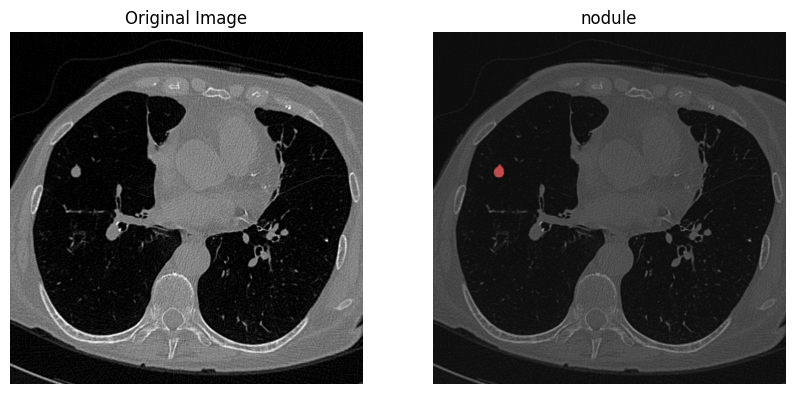

In [7]:
image_path = 'examples/CT_lung_nodule.dcm'
text_prompt = ['nodule']

image, pred_mask = inference_dicom(image_path, text_prompt, is_CT=True, site='lung')

### Check P Value

In [8]:
from inference_utils.output_processing import check_mask_stats

# P-value (adjusted) that the segmentation belongs to "nodule" in the CT-Chest class
# Lower p-value indicates it is likely the segmentation not belongs to the class. Recommended threshold is 0.05
adj_pvalue = check_mask_stats(image, pred_mask[0]*255, 'CT-Chest', 'nodule')
print(f'P-value: {adj_pvalue}')

target_dist.json:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

P-value: 0.5264537864232068


### Negative example

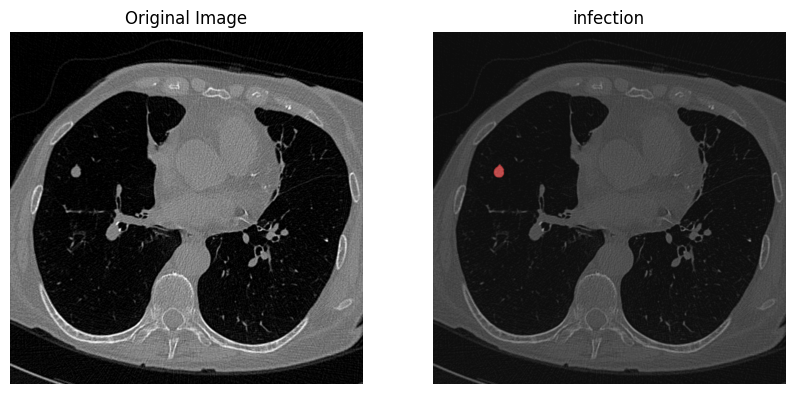

In [9]:
text_prompt = ['infection']

image, pred_mask = inference_dicom(image_path, text_prompt, is_CT=True, site='lung')

In [10]:
# P-value (adjusted) that the segmentation belongs to "nodule" in the CT-Chest class
# Lower p-value indicates it is likely the segmentation not belongs to the class. Recommend to use a threshold of 0.05
adj_pvalue = check_mask_stats(image, pred_mask[0]*255, 'CT-Chest', 'COVID-19 infection')
print(f'P-value: {adj_pvalue}')

P-value: 0.023389700400293572
